In [72]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import plotly.express as px

In [73]:
 # Converting multivalued attribute to list of values
def categorize_education(education):
    if pd.isna(education) or 'Primary' in education or 'Secondary' in education or 'Some college' in education or 'Associate' in education:
       return 'Basic Education'
    elif 'Bachelor' in education:
        return 'Bachelor’s Degree'
    elif  'Master' in education:
        return 'Master’s Degree'
    elif 'Professional' in education and 'doctor' not in education:
        return 'Professional Degrees'
    elif 'doctor' in education:
        return 'Doctoral Degrees'
    else:
        return 'Other'

def convert_to_int_years(row):
    if(not(pd.isna(row["YearsCodePro"]))):
        if(row["YearsCodePro"] == "Less than 1 year"):
            return(1)
        elif(row["YearsCodePro"] == "More than 50 years"):
            return(51)
        return(int(row['YearsCodePro']))
    else:
        return(np.nan)

In [74]:
def clean_data(data):
    EDA_5years = data  # Avoid modifying the original DataFrame
    # Splitting and cleaning columns
    EDA_5years.loc[:, "LanguageHaveWorkedWith"] = EDA_5years["LanguageHaveWorkedWith"].str.split(";").str[0]
    EDA_5years.loc[:, "DatabaseHaveWorkedWith"] = EDA_5years["DatabaseHaveWorkedWith"].str.split(";").str[0]
    EDA_5years.loc[:, "PlatformHaveWorkedWith"] = EDA_5years["PlatformHaveWorkedWith"].str.split(";").str[0]
    EDA_5years.loc[:, "WebframeHaveWorkedWith"] = EDA_5years["WebframeHaveWorkedWith"].str.split(";").str[0]
    EDA_5years.loc[:, "PlatformWantToWorkWith"] = EDA_5years["PlatformWantToWorkWith"].str.split(";").str[0]
    EDA_5years.loc[:, "DatabaseWantToWorkWith"] = EDA_5years["DatabaseWantToWorkWith"].str.split(";").str[0]
    EDA_5years.loc[:, "LanguageWantToWorkWith"] = EDA_5years["LanguageWantToWorkWith"].str.split(";").str[0]
    
    EDA_5years.loc[:, "YearsCodePro"] = EDA_5years.apply(convert_to_int_years, axis=1)
    
    EDA_5years.loc[:, 'Employment'] = EDA_5years['Employment'].apply(
        lambda x: x if isinstance(x, float) else x.split(',')[0].split(';')[0] if ';' in x.split(',')[0] else x.split(',')[0]
    )
     
   # Apply the cleaning logic with midpoint calculation for age ranges
    # EDA_5years.loc[:, "Age"] = EDA_5years['Age'].apply(clean_age)
   
    # Cleaning and replacing values in 'DevType'
    EDA_5years.loc[:, 'DevType'] = EDA_5years['DevType'].apply(lambda x: x if isinstance(x, float) else x.split(';')[0])
    EDA_5years.loc[:, 'DevType'] = EDA_5years['DevType'].replace({
        'Engineer, data': 'Data engineer',
        'Engineer, site reliability': 'Site reliability engineer'
    }, regex=False)
    EDA_5years.loc[:, 'DevType'] = EDA_5years['DevType'].replace({
        'Developer.*': 'Developer',
        'Other.*': 'Other',
        'Senior Executive.*': 'Senior Executive'
    }, regex=True)
    
    
    # Categorizing Education level
    EDA_5years.loc[:, 'EdLevel'] = EDA_5years['EdLevel'].apply(categorize_education)
    
    # Cleaning Country names
    EDA_5years.loc[:, "Country"] = EDA_5years["Country"].str.split(",").str[0]
    country_replacements = {
        'Turkey': 'Türkiye',
        'The former Yugoslav Republic of Macedonia': 'Macedonia',
        'Hong Kong (S.A.R.)': 'Hong Kong',
        'Democratic Republic of the Congo': 'Congo',
        'Libyan Arab Jamahiriya': 'Libya',
        'Swaziland': 'Eswatini',
        'Cape Verde': 'Cabo Verde'
    }
    EDA_5years.loc[:, 'Country'] = EDA_5years['Country'].replace(country_replacements)
    EDA_5years = EDA_5years[~EDA_5years['Country'].isin(['Nomadic', 'unknown'])].reset_index(drop=True)
    return EDA_5years

In [105]:
def null_treatment(data):
    
    pd.set_option('future.no_silent_downcasting', True)

    EDA_5years = data  # Avoid modifying the original DataFrame
    #Drop Nulls
    EDA_5years.dropna(subset=["DevType"], how="any", inplace = True)
    EDA_5years.dropna(subset=["ConvertedCompYearly"], how="any", inplace = True)

    #Fill null with 'unknown'
    cols_to_fill = ["EdLevel", "Employment", "Country","LanguageHaveWorkedWith", "DatabaseHaveWorkedWith", "PlatformHaveWorkedWith", 
                    "WebframeHaveWorkedWith", "LanguageWantToWorkWith", "DatabaseWantToWorkWith", "PlatformWantToWorkWith",
                    "MainBranch", "OrgSize"]
    EDA_5years.loc[:, cols_to_fill] = EDA_5years[cols_to_fill].fillna('unknown')    

    #fill YearsCodePro with group mean
    # Ensure 'YearsCodePro' is numeric to avoid warnings
    # EDA_5years.loc[:, 'YearsCodePro'] = pd.to_numeric(EDA_5years['YearsCodePro'], errors='coerce')
    summary_stats = EDA_5years.groupby(['DevType'])['YearsCodePro'].agg(['mean', 'median', 'std', 'count'])
    
    # Step 1: Calculate the mean of YearsCodePro per DevType
    devtype_means = EDA_5years.groupby('DevType')['YearsCodePro'].mean()

    # Step 2: Use the transform method to fill missing values with the corresponding mean
    EDA_5years['YearsCodePro'] = EDA_5years.groupby('DevType')['YearsCodePro'].transform(lambda x:x.fillna(devtype_means[x.name]))
                    
    
    
    return EDA_5years

In [106]:
def remove_outliers_iqr(data, cols):
    """
    Remove outliers from the specified columns of a DataFrame using the IQR method.
    
    Parameters:
    data (pd.DataFrame): The input DataFrame.
    columns (list): A list of columns to check for outliers.

    Returns:
    pd.DataFrame: The DataFrame with outliers removed.
    """
    EDA_5years= data
    for col in cols:
        Q1 = EDA_5years[col].quantile(0.25)
        Q3 = EDA_5years[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        EDA_5years = EDA_5years[(EDA_5years[col] >= lower_bound) & (EDA_5years[col] <= upper_bound)]
    return EDA_5years

In [107]:
data_2020 = pd.read_csv("survey_2020.csv")
data_2021 = pd.read_csv("survey_2021.csv")
data_2022 = pd.read_csv("survey_2022.csv")
data_2023 = pd.read_csv("survey_2023.csv")
data_2024 = pd.read_csv("survey_2024.csv")
data_2020['Year'] = 2020
data_2021['Year'] = 2021
data_2022['Year'] = 2022
data_2023['Year'] = 2023
data_2024['Year'] = 2024

In [109]:
# Rename and replace columns as the names are different
# For 2020
data_2020.rename(columns={
    'DatabaseWorkedWith': 'DatabaseHaveWorkedWith',
    'LanguageWorkedWith': 'LanguageHaveWorkedWith',
    'PlatformWorkedWith': 'PlatformHaveWorkedWith',
    'CurrencySymbol': 'Currency',
    'WebframeWorkedWith':'WebframeHaveWorkedWith',
    'LanguageDesireNextYear':'LanguageWantToWorkWith',
    'DatabaseDesireNextYear':'DatabaseWantToWorkWith',
    'PlatformDesireNextYear':'PlatformWantToWorkWith',
    'WebframeDesireNextYear':'WebframeWantToWorkWith',
    'ConvertedComp': 'ConvertedCompYearly'
}, inplace=True)
# common_columns = set(data_2024.columns) & set(data_2023.columns) & set(data_2022.columns) & set(data_2021.columns) & set(data_2020.columns)

In [110]:
#Combining both the columns
data_2024['PlatformHaveWorkedWith'] = data_2024['PlatformHaveWorkedWith'].str.cat(data_2024['ToolsTechHaveWorkedWith'], sep=';')
data_2023['PlatformHaveWorkedWith'] = data_2023['PlatformHaveWorkedWith'].str.cat(data_2023['ToolsTechHaveWorkedWith'], sep=';')
data_2022['PlatformHaveWorkedWith'] = data_2022['PlatformHaveWorkedWith'].str.cat(data_2022['ToolsTechHaveWorkedWith'], sep=';')
data_2021['PlatformHaveWorkedWith'] = data_2021['PlatformHaveWorkedWith'].str.cat(data_2021['ToolsTechHaveWorkedWith'], sep=';')

In [111]:
# Removing these column
# MainBranch,EdLevel,NEWCollabToolsHaveWorkedWith,ToolsTechHaveWorkedWith,RemoteWork,WorkExp
# Adding WebframeHaveWorkedWith
select_columns = ["Employment","EdLevel","Country","ConvertedCompYearly","LanguageHaveWorkedWith","DatabaseHaveWorkedWith","PlatformHaveWorkedWith","WebframeHaveWorkedWith",
                  "YearsCodePro","DevType","DatabaseWantToWorkWith","LanguageWantToWorkWith","PlatformWantToWorkWith","Year", "MainBranch","OrgSize"]
EDA_5_years_with_null_records = pd.concat([data_2023[select_columns],data_2024[select_columns],data_2022[select_columns],data_2021[select_columns],data_2020[select_columns]])
EDA_5_years_with_null_records.reset_index(drop=True, inplace=True)

# Display the DataFrame to verify
EDA_5_years_with_null_records.head()

,Employment,EdLevel,Country,ConvertedCompYearly,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,PlatformHaveWorkedWith,WebframeHaveWorkedWith,YearsCodePro,DevType,DatabaseWantToWorkWith,LanguageWantToWorkWith,PlatformWantToWorkWith,Year,MainBranch,OrgSize
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,None of these,NaN
1,"Employed, full-time","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",United States of America,285000.0,HTML/CSS;JavaScript;Python,Supabase,Amazon Web Services (AWS);Netlify;Vercel;Docke...,Next.js;React;Remix;Vue.js,9,"Senior Executive (C-Suite, VP, etc.)",Firebase Realtime Database;Supabase,Bash/Shell (all shells);C#;Dart;Elixir;GDScrip...,Fly.io;Netlify;Render,2023,I am a developer by profession,2 to 9 employees
2,"Employed, full-time","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",United States of America,250000.0,Bash/Shell (all shells);Go,NaN,Amazon Web Services (AWS);Google Cloud;OpenSta...,NaN,23,"Developer, back-end",NaN,Haskell;OCaml;Rust,NaN,2023,I am a developer by profession,"5,000 to 9,999 employees"
3,"Employed, full-time","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",United States of America,156000.0,Bash/Shell (all shells);HTML/CSS;JavaScript;PH...,PostgreSQL;Redis,Cloudflare;Heroku;Homebrew;npm;Vite;Webpack;Yarn,Node.js;React;Ruby on Rails;Vue.js;WordPress,7,"Developer, front-end",PostgreSQL;Redis,Bash/Shell (all shells);HTML/CSS;JavaScript;Ru...,Cloudflare;Heroku,2023,I am a developer by profession,100 to 499 employees
4,"Employed, full-time;Independent contractor, fr...","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Philippines,23456.0,HTML/CSS;JavaScript;TypeScript,BigQuery;Elasticsearch;MongoDB;PostgreSQL,Amazon Web Services (AWS);Firebase;Heroku;Netl...,Express;Gatsby;NestJS;Next.js;Node.js;React,4,"Developer, full-stack",Elasticsearch;MongoDB;PostgreSQL;Redis;Supabase,HTML/CSS;JavaScript;Python;Rust;TypeScript,Amazon Web Services (AWS);Cloudflare;Digital O...,2023,I am a developer by profession,20 to 99 employees


In [103]:
percent_missing = EDA_5_years_with_null_records.isnull().sum() * 100 / len(EDA_5_years_with_null_records)
missing_value_df = pd.DataFrame({'column_name': EDA_5_years_with_null_records.columns,
                                 'percent_missing': percent_missing})
missing_value_df

,column_name,percent_missing
Employment,Employment,0.949469
EdLevel,EdLevel,3.966055
Country,Country,2.555689
ConvertedCompYearly,ConvertedCompYearly,49.140342
LanguageHaveWorkedWith,LanguageHaveWorkedWith,4.841547
DatabaseHaveWorkedWith,DatabaseHaveWorkedWith,19.398120
PlatformHaveWorkedWith,PlatformHaveWorkedWith,35.291347
WebframeHaveWorkedWith,WebframeHaveWorkedWith,28.249896
YearsCodePro,YearsCodePro,26.250103
DevType,DevType,16.582710


In [112]:
#final data
cleaned_data = clean_data(EDA_5_years_with_null_records)
null_treated_data = null_treatment(cleaned_data)
columns_to_remove_outliers = ["ConvertedCompYearly"]
cleaned_data_no_outliers = remove_outliers_iqr(null_treated_data,cols=columns_to_remove_outliers)

In [113]:
percent_missing = cleaned_data_no_outliers.isnull().sum() * 100 / len(cleaned_data_no_outliers)
missing_value_df = pd.DataFrame({'column_name': cleaned_data_no_outliers.columns,
                                 'percent_missing': percent_missing})
missing_value_df

,column_name,percent_missing
Employment,Employment,0.0
EdLevel,EdLevel,0.0
Country,Country,0.0
ConvertedCompYearly,ConvertedCompYearly,0.0
LanguageHaveWorkedWith,LanguageHaveWorkedWith,0.0
DatabaseHaveWorkedWith,DatabaseHaveWorkedWith,0.0
PlatformHaveWorkedWith,PlatformHaveWorkedWith,0.0
WebframeHaveWorkedWith,WebframeHaveWorkedWith,0.0
YearsCodePro,YearsCodePro,0.0
DevType,DevType,0.0


In [114]:
#final cleaned data
cleaned_data_no_outliers.to_csv("cleaned_data1.csv")

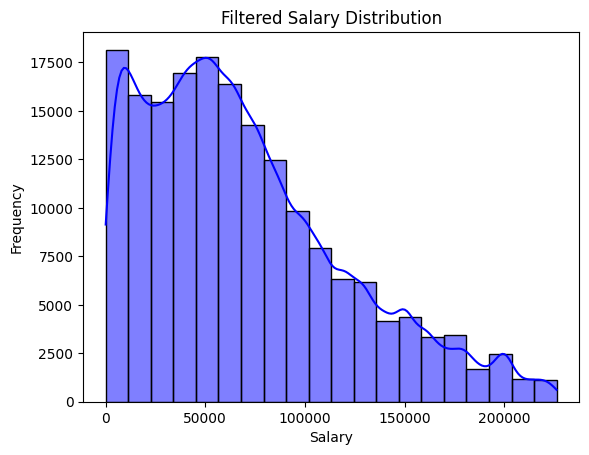

<Figure size 640x480 with 0 Axes>

In [115]:
#dropping NAN and after outlier removal
sns.histplot(cleaned_data_no_outliers["ConvertedCompYearly"],kde=True, bins=20, color='blue', edgecolor='black')
plt.title('Filtered Salary Distribution')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.show()
plt.savefig("Comp Distribution After NAN removal")

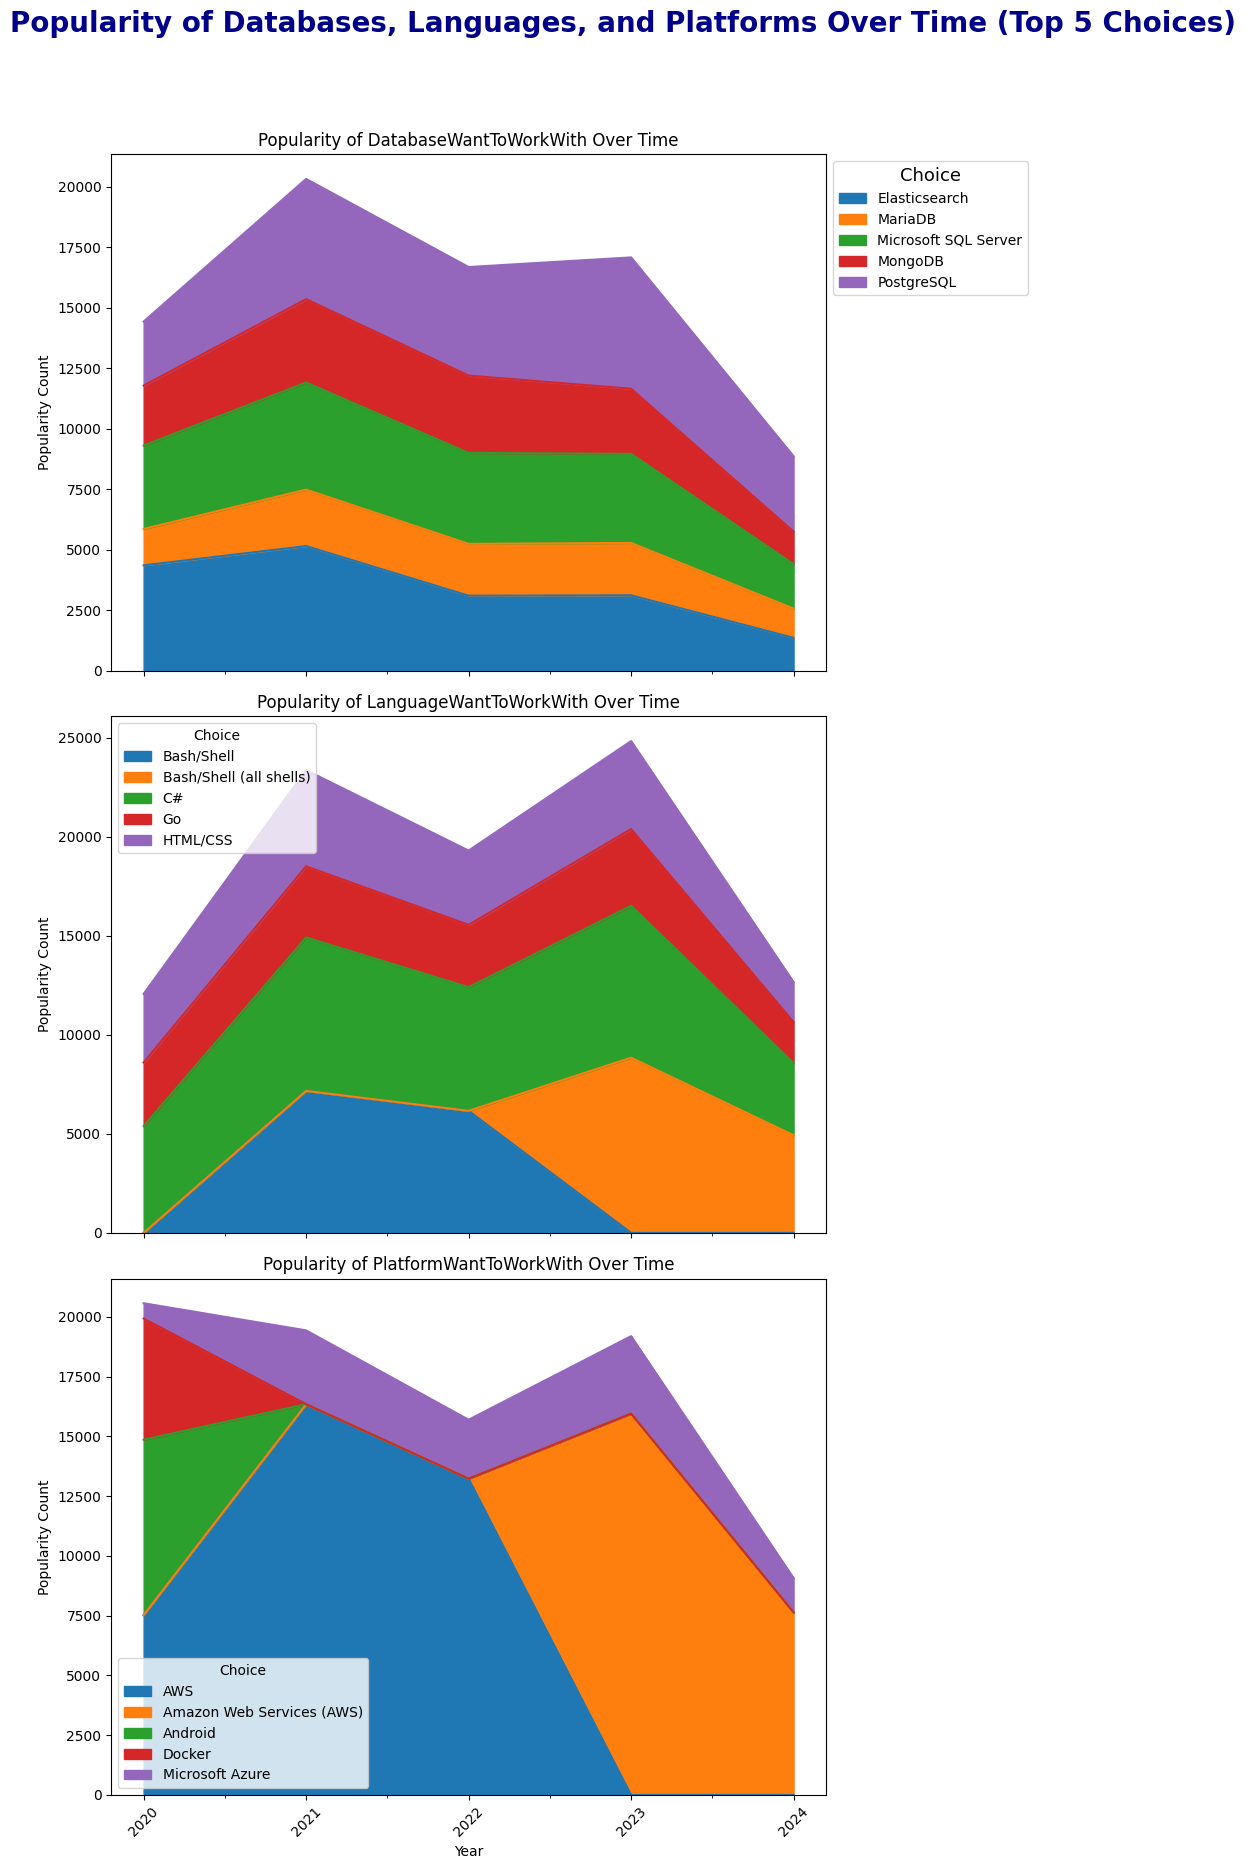

In [116]:
# Filter the data to focus on the three columns
columns_of_interest = ['DatabaseWantToWorkWith', 'LanguageWantToWorkWith', 'PlatformWantToWorkWith']

# Melt the DataFrame to create a long-form version for easier plotting
popular_melted = cleaned_data_no_outliers[['Year'] + columns_of_interest].melt(id_vars='Year', 
                                                                 value_vars=columns_of_interest, 
                                                                 var_name='Category', 
                                                                 value_name='Choice')

# Convert the 'Choice' column to strings to avoid any mixed data type issues
popular_melted['Choice'] = popular_melted['Choice'].astype(str)

# Filter out the "unknown" values to focus only on the choices that people have worked with
popular_melted_filtered = popular_melted[popular_melted["Choice"] != "unknown"]

# Get top 5 most repeated values for each column
top_5_counts = popular_melted_filtered.groupby(['Category', 'Choice']).size().reset_index(name="Count")
top_5_counts = top_5_counts.sort_values('Count', ascending=False)

# For each category, get the top 5 most repeated values
top_5_per_category = top_5_counts.groupby('Category').head(5)

# Create a pivot table to count occurrences of each choice by year and category, keeping only top 5 choices
popularity_over_time_filtered = (
    popular_melted_filtered[popular_melted_filtered['Choice'].isin(top_5_per_category['Choice'])]
    .groupby(["Year", "Category", "Choice"])
    .size()
    .reset_index(name="Count")
    .pivot_table(index="Year", columns=["Category", "Choice"], values="Count", fill_value=0)
)

# Define a custom color palette using Seaborn for better aesthetics
custom_colors = sns.color_palette("tab10", n_colors=len(top_5_per_category['Choice'].unique()))

# Plot each category as a separate area plot
fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

# Loop over the categories (Database, Language, Platform)
categories = popularity_over_time_filtered.columns.levels[0]

for i, category in enumerate(categories):
    subset = popularity_over_time_filtered[category]
    
    # Plot the area plot for each category
    subset.plot.area(
        stacked=True,
        ax=axes[i],
        title=f"Popularity of {category} Over Time",
        color=custom_colors[:len(subset.columns)]  # Assign distinct colors for each choice
    )
    axes[i].set_ylabel("Popularity Count")
    axes[i].set_xticks(subset.index)  # Ensure ticks correspond to the Year values
    axes[i].set_xticklabels(subset.index, rotation=45)  # Avoid overlap and ensure readability

# Enhance overall layout and title
plt.xlabel("Year")
plt.suptitle(
    "Popularity of Databases, Languages, and Platforms Over Time (Top 5 Choices)", 
    fontsize=20, 
    fontweight='bold',    # Make the title bold
    color='darkblue',     # Choose an appealing color
    y=1.02,               # Adjust vertical spacing
    ha='center',          # Horizontal alignment
    va='bottom'           # Vertical alignment
)

# Adjust legend to avoid overlap
axes[0].legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=10, title="Choice", title_fontsize='13')

# Optionally, you can try adding multiple columns to the legend if it still overflows
# axes[0].legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=10, title="Choice", title_fontsize='13', ncol=2)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make space for the legend
plt.show()


**Bivariate Analysis**

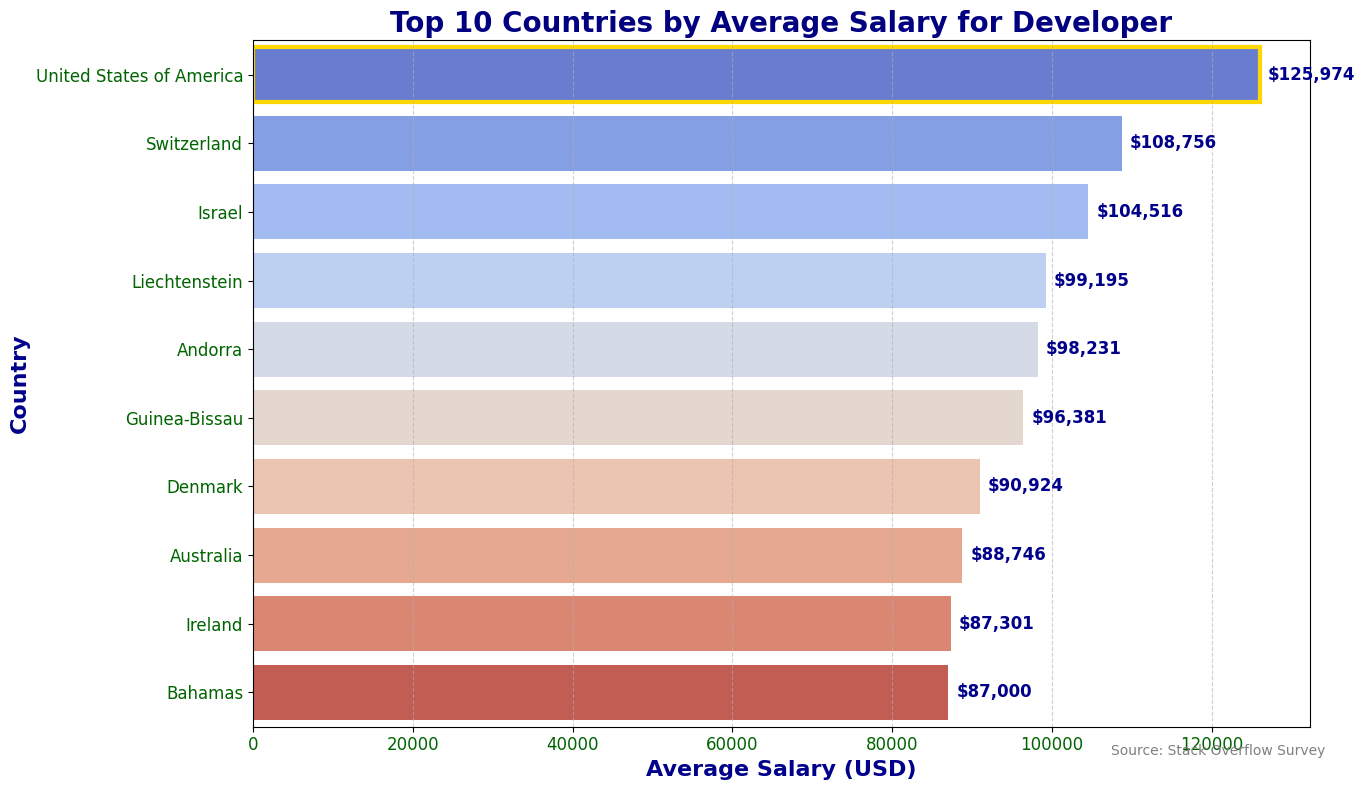

In [117]:
# Standardize the country names
cleaned_data_no_outliers.loc[:,'Country'] = cleaned_data_no_outliers['Country'].replace(
    {'United States': 'United States of America', 'US': 'United States of America'}
)

# Specify developer type to analyze
developer_type = "Developer"  # Change this to the devType you're interested in

# Filter the dataset for the specified developer type
filtered_df = cleaned_data_no_outliers[
    cleaned_data_no_outliers['DevType'].str.contains(developer_type, na=False, case=False)
]

# Calculate the average salary per country for the specified developer type
avg_salary_by_country = (
    filtered_df.groupby('Country')['ConvertedCompYearly']
    .mean()
    .sort_values(ascending=False)
    .head(10)  # Top N countries
)

# Create the horizontal bar plot for top N countries
plt.figure(figsize=(14, 8))  # Larger figure for presentation
barplot = sns.barplot(
    x=avg_salary_by_country.values,
    y=avg_salary_by_country.index,
    hue=avg_salary_by_country.index,
    palette='coolwarm',
    legend=False
)

# Enhance the plot aesthetics
plt.title(
    f'Top 10 Countries by Average Salary for {developer_type}',
    fontsize=20,
    fontweight='bold',
    color='navy'
)
plt.xlabel('Average Salary (USD)', fontsize=16, fontweight='bold', color='darkblue')
plt.ylabel('Country', fontsize=16, fontweight='bold', color='darkblue')
plt.xticks(fontsize=12, color='darkgreen')
plt.yticks(fontsize=12, color='darkgreen')
plt.grid(True, linestyle='--', alpha=0.6, axis='x')

# Add annotations for precise salary values
for i, (value, country) in enumerate(zip(avg_salary_by_country.values, avg_salary_by_country.index)):
    barplot.text(
        value + 1000,  # Position slightly to the right of the bar
        i,  # Position aligned with the bar
        f'${value:,.0f}',  # Format value as currency
        fontsize=12,
        color='darkblue',
        fontweight='bold',
        va='center'
    )

# Highlight specific countries for emphasis (optional)
highlight_countries = ['United States of America']
for bar, country in zip(barplot.patches, avg_salary_by_country.index):
    if country in highlight_countries:
        bar.set_edgecolor('gold')
        bar.set_linewidth(3)

# Add a logo or annotation (optional)
plt.text(
    0.95, 0.05, 'Source: Stack Overflow Survey', 
    fontsize=10, color='gray', transform=plt.gcf().transFigure, ha='right'
)

# Show the plot
plt.tight_layout()
plt.show()
